In [1]:
%matplotlib notebook

from __future__ import division
import math
import sys
import os
import csv
import sqlite3
import numpy as np
import pandas
from scipy.interpolate import interp1d

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

sys.path.append('.')
import scripts2d.utils as u
from wde.estimator import WaveletDensityEstimator
from wde.thresholding import soft_threshold, hard_threshold, block_threshold, soft_block_threshold


In [2]:
def contour_plot_it(dist, data, fname=None):
    fig = plt.figure()
    X = np.linspace(0.0,1.0, num=75)
    Y = np.linspace(0.0,1.0, num=75)
    XX, YY = np.meshgrid(X, Y)
    Z = dist.pdf((XX, YY))
    cs = plt.contour(XX, YY, Z, alpha=0.7)
    plt.clabel(cs, inline=1, fontsize=10)
    plt.scatter(data[:,0], data[:,1], s=2)
    if fname is not None:
        plt.savefig('data/plots-tex/%s' % fname, pad_inches=0.0, orientation='portrait', frameon=False)
    #plt.clf()
    plt.show()
    
def plot_it(dist, fname=None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X = np.linspace(0.0,1.0, num=75)
    Y = np.linspace(0.0,1.0, num=75)
    XX, YY = np.meshgrid(X, Y)
    Z = dist.pdf((XX, YY))
    # see http://mpastell.com/2013/05/02/matplotlib_colormaps/
    surf = ax.plot_surface(XX, YY, Z, edgecolors='k', linewidth=0.5, cmap=cm.get_cmap('BuGn'))
    #ax.set_zlim(0, 5)
    if fname is not None:
        plt.savefig('data/paper-1/%s' % fname, pad_inches=0.0, orientation='portrait', frameon=False)
    #plt.clf()
    plt.show()

def plot_1():
    for dist_code in ['beta', 'mult']:
        dist = u.dist_from_code(dist_code)
        plot_it(dist, 'true-%s-3d.eps' % dist_code)
    
#plot_1()


In [3]:
def plot_oldf():
    df = pandas.read_csv('data/old-faithful.txt', sep='\s+')
    df_norm = (df - df.min()) / (df.max() - df.min())
    data = df_norm.as_matrix(('eruptions', 'waiting'))
    wde = WaveletDensityEstimator('sym7', j0=0, j1=2, k=1)
    wde.fit(data)
    X = np.linspace(0.0,1.0, num=75)
    Y = np.linspace(0.0,1.0, num=75)
    XX, YY = np.meshgrid(X, Y)
    Z = wde.pdf((XX, YY)) / ((df['eruptions'].max() - df['eruptions'].min()) * (df['waiting'].max() - df['waiting'].min()))
    X2 = np.linspace(df['eruptions'].min(),df['eruptions'].max(), num=75)
    Y2 = np.linspace(df['waiting'].min(),df['waiting'].max(), num=75)
    XX2, YY2 = np.meshgrid(X2, Y2)
    fig = plt.figure()
    cmap = cm.get_cmap('BuGn')
    zmax = Z.max()
    levels = np.linspace(0.0, zmax, 10)
    plt.scatter(df['eruptions'], df['waiting'], s=2)
    pc = plt.pcolor(XX2, YY2, Z, alpha=1.0, cmap=cmap, vmin=0.0, vmax=zmax)
    cs = plt.contour(XX2, YY2, Z, levels=levels, alpha=0.8, cmap=cmap, vmin=0.0, vmax=zmax)
    plt.xlabel('Duration')
    plt.ylabel('Waiting time')
    cbar = fig.colorbar(pc, format='%4.3f', cmap=cmap, filled=True, alpha=1.0)
    cbar.set_ticks(levels)
    print cbar.ax.get_ylim()
    for lvl in levels:
        cbar.ax.plot([0, 1], [lvl/zmax, lvl/zmax], 'k:')
    pc.remove()
    #cbar = mpl.colorbar.ColorbarBase(plt.gca(), cmap=cmap, orientation='vertical')
    #cbar.add_lines(cs)
    #plt.clabel(cs, inline=1, fontsize=10)
    
    plt.savefig('data/paper-1/old-faithful-data.eps')
    plt.show()
    fig = plt.figure(figsize=(10,6))
    ax = fig.gca(projection='3d')
    X2 = np.linspace(df['eruptions'].min(),df['eruptions'].max(), num=75)
    Y2 = np.linspace(df['waiting'].min(),df['waiting'].max(), num=75)
    XX2, YY2 = np.meshgrid(X2, Y2)
    surf = ax.plot_surface(XX2, YY2, Z, edgecolors='k', linewidth=0.5, cmap=cmap)
    plt.xlabel('Duration')
    plt.ylabel('Waiting time')
    plt.savefig('data/paper-1/old-faithful-wde.eps')
    plt.show()
#plot_oldf()

In [4]:
DBNAME = 'data/%s/db4/data.db'
CSVNAME = 'data/%s/db4/all-ise.csv'

def create_table(conn):
    sql = """
    CREATE TABLE IF NOT EXISTS results (
     fname varchar(256) NOT NULL,
     n integer NOT NULL,
     j0 integer NOT NULL,
     j1 integer NOT NULL,
     k integer NOT NULL,
     ise real NOT NULL,
     etime real NOT NULL
     )
    """
    conn.execute(sql)
    print 'results created'

def connect(dist_code):
    dbname = DBNAME % dist_code
    if not os.path.isfile(dbname):
        conn = sqlite3.connect(dbname)
        create_table(conn)
    else:
        conn = sqlite3.connect(dbname)
    return conn

def read_rows(fcsv):
    for row in fcsv:
        if len(row) == 0 or len(row[0]) == 0:
            continue
        try:
            # fname, dist_code, wave_code, n, j0, j1, k, ise, elapsed_time
            yield row[0], int(row[3]), int(row[4]), int(row[5]), int(row[6]), float(row[7]), float(row[8])
        except:
            print 'E:',fcsv.line_num, len(row)

def load_data(dist_code):
    csvname = CSVNAME % dist_code
    with open(csvname, 'r') as f:
        fcsv = csv.reader(f)
        with connect(dist_code) as conn:
            conn.execute('delete from results')
            headers = next(fcsv)
            print headers
            for fname, n, j0, j1, k, ise, etime in read_rows(fcsv):
                try:
                    conn.execute('insert into results (fname, n, j0, j1, k, ise, etime) values (?,?,?,?,?,?,?)', (fname, n, j0, j1, k, ise, etime))
                except sqlite3.Error as e:
                    print e
                    print fname, n
                    raise
    print 'Done'

def exec_gen(conn, sql, args=()):
    cur = conn.execute(sql, args)
    row = cur.fetchone()
    while row is not None:
        yield row
        row = cur.fetchone()

In [5]:
def best_for(dist_code):
    sql = "select distinct j0, j1 from results where n = ? order by j0, j1"
    sql3 = "select ise from results where n = ? and j0 = ? and j1 = ? and k = 1 order by ise"
    s = """{n_cell:s}   & {j1:d}    & {mise:f} \\\\"""
    name = 'Beta' if dist_code == 'beta' else 'Gaussians mixture'
    print """\\begin{minipage}[t]{0.45\\textwidth}
	\\centering
	\\textbf{%s} \\\\
	\\vspace{6pt}
	\\begin{tabular}{|l|r|r|}
		\\hline
		\\textbf{n} & \\textbf{Best J} & \\textbf{Best k} & \\textbf{MISE} & \\textbf{Std. ISE} \\\\
    """ % name
    with connect(dist_code) as conn:
        data = {}
        for n in [500, 1000, 2000, 5000]:
            params = []
            first_row = True
            for row in exec_gen(conn, sql, (n,)):
                j0, j1 = row
                if j0 == 0: continue
                ises = [vs[0] for vs in list(exec_gen(conn, sql3, (n, j0, j1)))]
                median = ises[len(ises)//2]
                n_cell = ("\\multirow{5}{*}{%d}" % n) if first_row else ""
                if first_row:
                    print "\\hline"
                else:
                    print "\\cline{2-3}"
                print s.format(n_cell=n_cell, j1=j1, mise=median)
                first_row = False
    print """		\\hline
        \\end{tabular}
    \\end{minipage}"""

def do_table():
    print """
        \\begin{table}[ht!]
        \\centering
    """
    for dist_code in ['beta', 'mult']:
        best_for(dist_code)
    print """
        \\caption{Simulation results}
        \\end{table}
    """
    

<IPython.core.display.Javascript object>


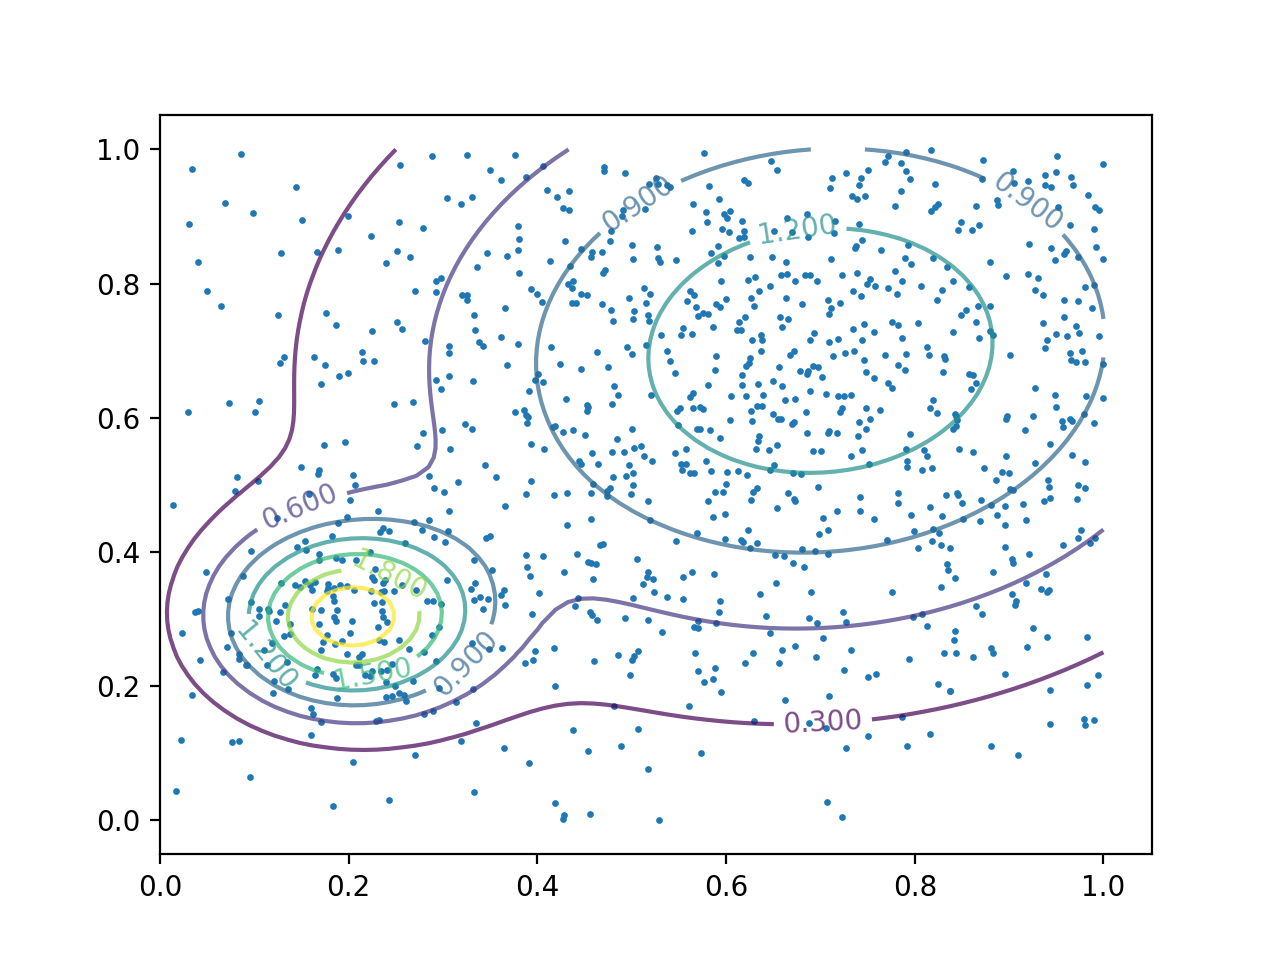

/usr/local/lib/python2.7/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


ISE>> 0.245071047465


<IPython.core.display.Javascript object>


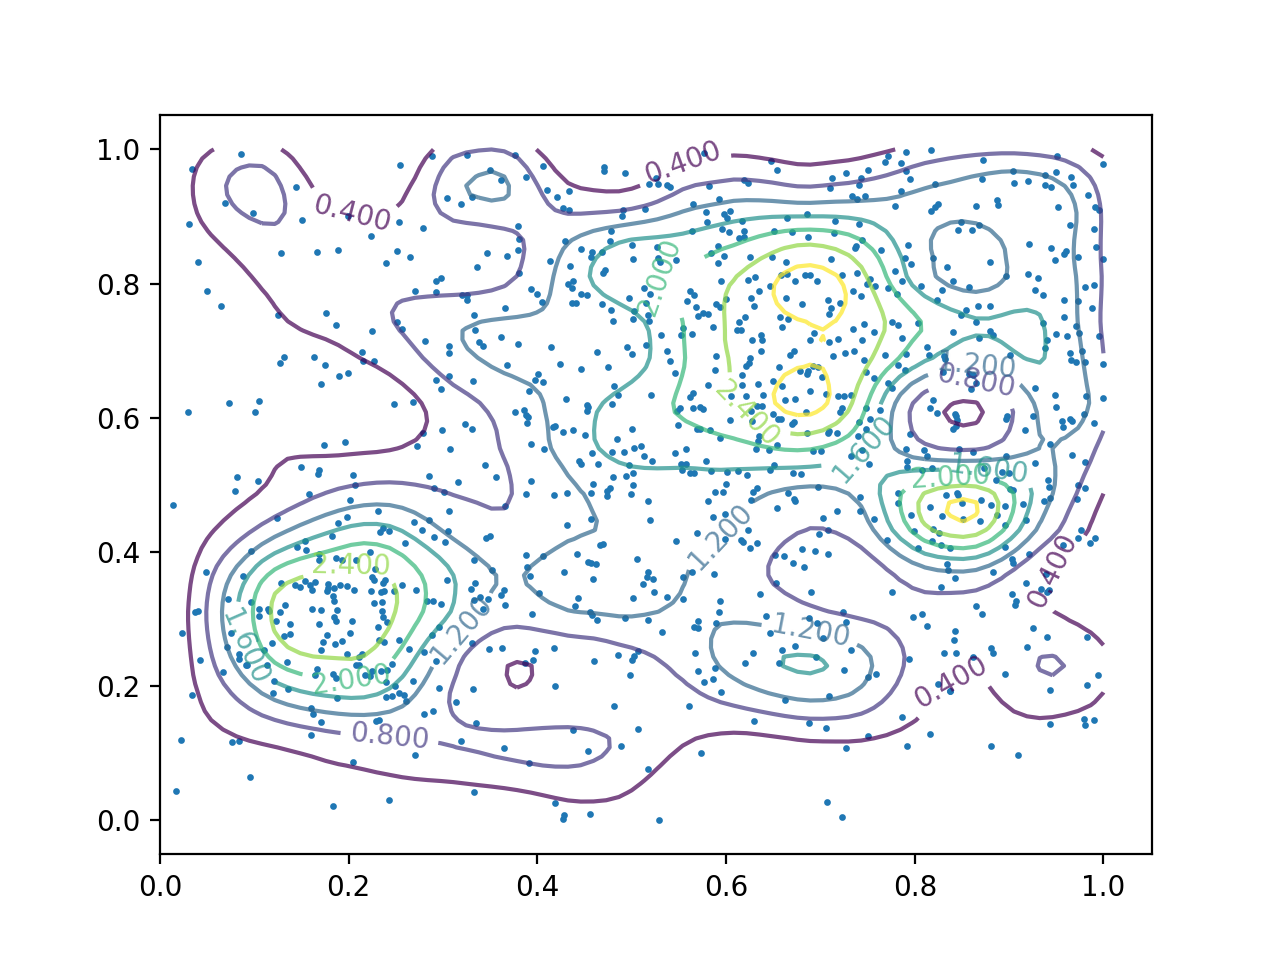

ST (0.000000,1.000000) 0.428571428571 (3) > 0.184960267538 0.00885200197914
ST (0.142857,0.714286) 0.428571428571 (3) > 0.184960267538 0
NEW ISE>> 0.184960267538
ISE 2>> 0.184960267538
c 0.428571428571


<IPython.core.display.Javascript object>


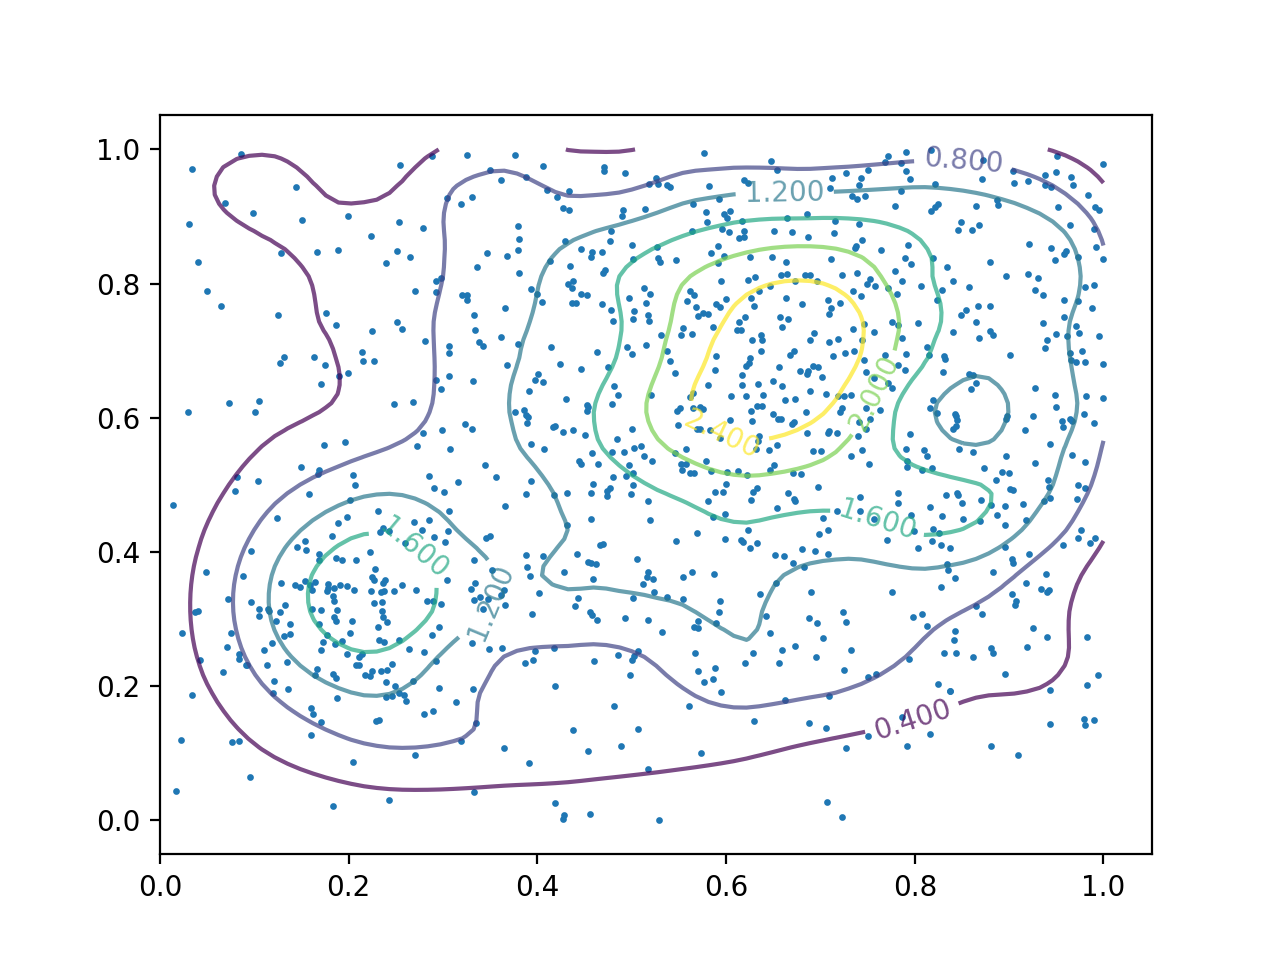

In [6]:
def plot_n_vs_mise():
    data = []
    with connect() as conn:
        sql = "select n, min(ise) from results group by n"
        for row in exec_gen(conn, sql):
            data.append(row)
    data = np.array(data)
    plt.plot(data[:,0], data[:,1], 'b:')
    plt.title('Sample size vs MISE - Beta')
    plt.xlabel('n')
    plt.ylabel('MISE')
    plt.show()

def get_best_for_n():
    with connect() as conn:
        sql = "select n, j0, j1, k, avg(ise) as mise from results group by n, j0, j1, k"
        data = {}
        for row in exec_gen(conn, sql):
            n, j0, j1, k, mise = row
            if n not in data:
                data[n] = []
            if j1 < j0: j1 = None
            data[n].append((j0, j1, k, mise))
        nn = data.keys()
        nn.sort()
        print 'n, j0, j1, k, MISE'
        for n in nn:
            data[n].sort(key=(lambda tt: tt[3]))
            print n, 'j0=%d, j1=%d, k=%d' % data[n][0][0:3]

def get_best_params_for_n():
    data = {}
    with connect() as conn:
        sql = "select n, j0, j1, k, ise from results order by n, j0, j1, k"
        curparams = None
        curdata = []
        summary = []
        # calculate robust MISE from data for n, j0, j1, k
        for row in exec_gen(conn, sql):
            params = row[0:4]
            ise = row[4]
            if curparams == params:
                curdata.append(ise)
            else:
                if curparams is not None:
                    rmise = np.median(np.array(curdata))
                    summary.append((curparams, rmise))
                curdata = [ise]
                curparams = params
        if curparams is not None:
            rmise = np.median(np.array(curdata))
            summary.append((curparams, rmise))
        # now pick best j0, j1, k for each n
        min_rmise = {}
        curdata = []
        for params, rmise in summary:
            n, j0, j1, k = params
            if n in min_rmise:
                _, val = min_rmise[n]
                if rmise < val:
                    min_rmise[n] = ((j0, j1, k), rmise)
            else:
                min_rmise[n] = ((j0, j1, k), rmise)
        nn = min_rmise.keys()
        nn.sort()
        mises = []
        plt.figure()
        for n in nn:
            params, mise = min_rmise[n]
            #print n, '(j0,j1,k)=', params,'MISE=', mise
            mises.append(mise)
            plt.text(n if n<=4000 else n - 1350, mise + (0.006 if n<=4000 else -0.008), str(params))
        plt.scatter(nn, mises)
        plt.xlabel('n')
        plt.ylabel('MISE')
        plt.title('Best j0, j1, k per sample size (Bivariate Beta)')
        plt.show()

def average_after_best_per_sample():
    pass


def plot_example(n, **kwargs):
    dist = u.dist_from_code('mult')
    data = dist.rvs(n)
    #plot_it(dist)
    contour_plot_it(dist, data, fname='true-mult.eps')
    #return
    wde = WaveletDensityEstimator('db6', **kwargs)
    wde.fit(data)
    XX, YY = u.mise_mesh()
    Z = dist.pdf((XX, YY))
    ise = u.calc_ise(wde.pdf, Z)
    print 'ISE>>', ise
    #plot_it(wde, 'wde-plain.eps')
    contour_plot_it(wde, data, fname='wde-plain.eps') #, fname='mult-nothreshold.j0={j0:d}.j1={j1:d}.k={k:d}.eps'.format(**kwargs))
    #return
    #plt.figure()
    #plt.hist(cs, bins=40, normed=True)
    #plt.show()
    #block_thresholding_calc(wde, ise, Z)
    ise1, th_v = soft_threshold_calc(wde, ise, Z)
    print 'ISE 2>>', ise1
    print 'c', th_v
    contour_plot_it(wde, data, fname='wde-threshold.eps') #, fname='mult-nothreshold.j0={j0:d}.j1={j1:d}.k={k:d}.eps'.format(**kwargs))
    #ise2, th_v1, th_v2 = block_thresholding_calc(wde, ise, Z)
    #if ise1 < ise2:
    #    wde.thresholding = soft_threshold(th_v)
    #    wde.pdf = wde.calc_pdf()
    #    title = 'Soft threshold = %f' % th_v
    #else:
    #    title = 'Pseudo-soft threshold %f, %f' % (th_v1, th_v2)
    #print title
    #plot_it(wde) #, 'wde-threshold.eps')
    #wde.thresholding = hard_block_threshold(th_v / math.sqrt(th_nn))
    #wde.pdf = wde.calc_pdf()
    #ise3 = u.calc_ise(wde.pdf, Z)
    #print 'ISE 3>>', ise3
    return

def block_thresholding_calc(wde, ise, Z):
    # hard-block thresholding calculation
    tt1_0 = 0
    tt1_1 = 1
    tt2_0 = 0
    tt2_1 = 1/10
    err = 1
    best_ise = ise
    best_tt1 = tt1_1
    best_tt2 = tt2_1
    best_i1 = 7
    best_i2 = 7
    while err > 0.000001:
        err = 0
        for i1 in range(8):
            for i2 in range(8): 
                tt_i1 = tt1_0 + (tt1_1 - tt1_0) * i1 / 7
                tt_i2 = tt2_0 + (tt2_1 - tt2_0) * i2 / 7
                wde.thresholding = soft_block_threshold(tt_i1, tt_i2) # / (math.sqrt(kwargs['j1']-kwargs['j0']+1) / math.sqrt(n)))
                wde.pdf = wde.calc_pdf()
                new_ise = u.calc_ise(wde.pdf, Z)
                if new_ise < best_ise:
                    err = best_ise - new_ise
                    best_ise = new_ise
                    best_tt1 = tt_i1
                    best_tt2 = tt_i2
                    best_i1 = i1
                    best_i2 = i2
        print 'BT (%f,%f)x(%f,%f)' % (tt1_0, tt1_1, tt2_0, tt2_1), best_tt1, best_tt2, '(%d, %d)' % (best_i1, best_i2),'>', best_ise, err
        i1_0 = max(best_i1 - 1, 0)
        i1_1 = min(best_i1 + 1, 7)
        tt1_0, tt1_1 = tt1_0 + (tt1_1 - tt1_0) * i1_0 / 7, tt1_0 + (tt1_1 - tt1_0) * i1_1 / 7
        i2_0 = max(best_i2 - 1, 0)
        i2_1 = min(best_i2 + 1, 7)
        tt2_0, tt2_1 = tt2_0 + (tt2_1 - tt2_0) * i2_0 / 7, tt2_0 + (tt2_1 - tt2_0) * i2_1 / 7
    wde.thresholding = soft_block_threshold(best_tt1, best_tt2) # / (math.sqrt(kwargs['j1']-kwargs['j0']+1) / math.sqrt(n)))
    wde.pdf = wde.calc_pdf()
    new_ise = u.calc_ise(wde.pdf, Z)            
    print 'NEW ISE>>', new_ise
    return (new_ise, best_tt1, best_tt2)

def soft_threshold_calc(wde, ise, Z):
    # hard-block thresholding calculation
    tt0 = 0
    tt1 = 1
    err = 1
    best_ise = ise
    best_tt = tt1
    best_i = 7
    while err > 0.000001:
        err = 0
        for i in range(8):
            tt_i = tt0 + (tt1 - tt0) * i / 7
            wde.thresholding = soft_threshold(tt_i) # / (math.sqrt(kwargs['j1']-kwargs['j0']+1) / math.sqrt(n)))
            wde.pdf = wde.calc_pdf()
            new_ise = u.calc_ise(wde.pdf, Z)
            if new_ise < best_ise:
                err = best_ise - new_ise
                best_ise = new_ise
                best_tt = tt_i
                best_i = i
        print 'ST (%f,%f)' % (tt0, tt1), best_tt, '(%d)' % best_i, '>', best_ise, err
        i0 = max(best_i - 2, 0)
        i1 = min(best_i + 2, 7)
        tt0, tt1 = tt0 + (tt1 - tt0) * i0 / 7, tt0 + (tt1 - tt0) * i1 / 7
    wde.thresholding = soft_threshold(best_tt) # / (math.sqrt(kwargs['j1']-kwargs['j0']+1) / math.sqrt(n)))
    wde.pdf = wde.calc_pdf()
    new_ise = u.calc_ise(wde.pdf, Z)            
    print 'NEW ISE>>', new_ise
    return (new_ise, best_tt)

def save(code):
    dist = u.dist_from_code(code)
    plot_it(dist, fname='true-%s.eps' % code)


#load_data()
#get_best_params_for_n()
#get_best_for_n()
#plot_n_vs_mise()
#plot_example(1000, j0=0, j1=2, k=1)
#save('beta')

In [7]:
def make_table():
    s = """\\bigstrut\\\\
		\\hline
		{n:d}   & {j0:d}  & {j1:d}    & {ks:s} &{k:d} & {mise:f}
        """
    data = []
    with connect() as conn:
        sql = "select n, j0, j1, k, avg(ise) as mise from results group by n, j0, j1, k"
        n = None
        ps = None
        for row in exec_gen(conn, sql):
            if n != row[0]:
                if n is not None:
                    data.append(dict(n=ps[0], j0=ps[1], j1=ps[2], k=ps[3], ks=ks, mise=ps[4]))
                n = row[0]
                ps = row
                ks = []
            if row[4] < ps[4]:
                ps = row
            if row[3] not in ks:
                ks.append(row[3])                
    data.append(dict(n=ps[0], j0=ps[1], j1=ps[2], k=ps[3], ks=ks, mise=ps[4]))
    print data
    with open('data/table-beta.txt', 'w') as f:
        for row in data:
            f.write(s.format(**row))
    print 'Done'
    
#make_table()

In [8]:
def vals():
    data = []
    with connect() as conn:
        sql = "select n, j0, j1, avg(ise) as mise from results where k = 1 group by n, j0, j1"
        n = None
        ps = None
        for row in exec_gen(conn, sql):
            print row
    print 'Done'
    
#vals()

In [9]:
def yyy():
    df = pandas.read_csv('data/old-faithful.txt', sep='\s+')
    print df['eruptions'].count()
    print df[df['eruptions'] < 3.25]['eruptions'].count()
#yyy()